In [143]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import graphviz 

## Load data

In [144]:
dataset = load_breast_cancer()
df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
#df['benign'] = [dataset.target_names[t] for t in dataset.target]
#display(df[18:28])

X = df[feature_names].copy()
X['one'] = 1
X = X.values
#X = X/X.max(axis=0)


y=target
#std=y.std()

#y_max=max(y)
#y_min=min(y)
#y_mean=y.mean()

#y=(y-y_mean)/std

#y=y/std

y=np.array(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 11)

n_train=X_train.shape[0]
n_test=X_test.shape[0]
m=X_train.shape[1]
print(n_train, n_test, m)

df['y'] = np.array(y)
display(df.head(5))
feature_names_one=list(feature_names) + ["one"]

df_train=pd.DataFrame(data=X_train, columns=[feature_names_one])
df_train['y'] = y_train



455 114 31


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,y
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


# XGB Tree

In [145]:
class SplitResult():
    similarity=0
    similarity_gain=0
    i_feature=-1
    split_value=None
    split_quantile=0
    # left
    left_X=None
    left_y=None
    left_y_previous=None
    left_similarity=0
    left_n=0
    # right
    right_X=None
    right_y=None
    right_y_previous=None
    right_similarity=0
    right_n=0
    
class Branch:
    no=0
    depth=1
    i_feature=-1
    split_value=0
    split_quantile=0
    similarity=0
    similarity_gain=0
    n_samples=0
    value=[]
    X=None
    y=None
    y_previous=None
    
    
    left_branch=None
    right_branch=None
    
    def value(self, _lambda):
        
        return np.sum(self.y)/(np.sum(self.y_previous * (1 - self.y_previous))+_lambda)

    
    def is_leaf(self):
        return self.left_branch is None and self.right_branch is None

In [146]:
from sklearn.metrics import r2_score
class XGBTree():
    
    _lambda=1
    node_number=0
    the_tree=None
    max_depth=3
    gamma=2
    colsample_bynode=1.0
    
    def __init__(self, max_depth=3, _lambda=1, gamma=2, colsample_bynode=1.0):
        
        self.max_depth = max_depth
        self._lambda =_lambda
        self.gamma = gamma
        self.colsample_bynode = colsample_bynode

    def get_similarity(self, y, y_previous):
        #a=np.array(a)
        sim=np.sum(y)**2/(np.sum(y_previous * (1-y_previous))+self._lambda)

        return sim
    
    def get_colsample_bynode_indics(self, n_features):
        if n_features==1:
            return [1]

        if self.colsample_bynode>1:
            raise ValueError("colsample_bynode must be smaller than or equal to 1.0")

        n_selected_features=int(self.colsample_bynode * n_features)
        if n_selected_features==n_features:
            return list(range(n_features))


        old_list=list(range(n_features))
        new_list=[]
        for i in range(n_selected_features):
            selected = random.choice(old_list)
            while selected in new_list:
                selected = random.choice(old_list)
            new_list.append(selected)
        return new_list
    
    def find_best_split(self, X, y, y_previous):
        n_features=X.shape[1]
        best_sr=SplitResult()
        # colsample_bynode
        selected_features = self.get_colsample_bynode_indics(n_features)
        for i_feature in selected_features:
            f=X[:,i_feature]
            # Approximate Algorithm 
            # Instead of Basic Exact Greedy Algorithm
            quantiles = np.quantile(f, [.25,.5,.75]) 
            for split_valie, split_quantile in zip(quantiles, [.25,.5,.75]):
                sr = SplitResult()
                sr.i_feature=i_feature
                condition = f<split_valie
                #print(condition)
                # left
                sr.left_y = y[condition]
                sr.left_y_previous=y_previous[condition]
                sr.left_n = len(sr.left_y)
                if sr.left_n == 0:
                    continue
                sr.left_similarity = self.get_similarity(sr.left_y, sr.left_y_previous)

                # right
                sr.right_y = y[~condition]
                sr.right_y_previous=y_previous[~condition]
                sr.right_n = len(sr.right_y)
                if sr.right_n == 0:
                    continue
                sr.right_similarity = self.get_similarity(sr.right_y, sr.right_y_previous)

                sr.similarity = sr.left_similarity + sr.right_similarity
                #sr.print_me()
                if sr.similarity>best_sr.similarity:
                    best_sr=sr
                    best_sr.left_X = X[condition,:]
                    best_sr.right_X = X[~condition,:]
                    best_sr.split_value = split_valie
                    best_sr.split_quantile = split_quantile
        return best_sr
    

    def fit_inner(self, X, y, y_previous, depth, branch_similarity):
        branch = Branch()
        branch.no=self.node_number
        self.node_number+=1
        branch.similarity=branch_similarity
        branch.n_samples = len(y)
        branch.X=X
        branch.y=y
        branch.y_previous = y_previous

        if depth==self.max_depth:
            #print("leaf")

            return branch
        else:
            sr=self.find_best_split(X, y, y_previous)
            if sr.i_feature==-1:
                return branch

            sr.similarity_gain=sr.similarity-branch_similarity

            #sr.print_me()
            branch.i_feature=sr.i_feature
            branch.split_value = sr.split_value
            branch.split_quantile = sr.split_quantile
            branch.similarity_gain=sr.similarity_gain
            #print("branch")
            branch.left_branch=self.fit_inner(sr.left_X, sr.left_y, sr.left_y_previous, depth+1, branch_similarity=sr.left_similarity)
            branch.right_branch=self.fit_inner(sr.right_X, sr.right_y, sr.right_y_previous, depth+1, branch_similarity=sr.right_similarity)

            return branch
        
    def fit(self, X, y, y_previous):
        self.node_number=0
        similarity=self.get_similarity(y, y_previous)
        self.tree=self.fit_inner(X, y, y_previous, 0, branch_similarity=similarity)
        
    def prune_inner(self, b: Branch):
        if b.is_leaf():
            return
        self.prune_inner(b.left_branch)
        self.prune_inner(b.right_branch)
        if b.left_branch.is_leaf() and b.right_branch.is_leaf():
            if b.similarity_gain<self.gamma:
                b.left_branch=None
                b.right_branch=None
        
    def prune(self):
        self.prune_inner(self.tree)
        
    def predict_one_inner(self, tree:Branch, x):
        if tree.is_leaf():
            return tree.value(self._lambda)
        if x[tree.i_feature]<tree.split_value:
            return self.predict_one_inner(tree.left_branch, x)
        else:
            return self.predict_one_inner(tree.right_branch, x)

    def predict_inner(self, tree:Branch, X):
        y=[]
        for x in X:
            t=self.predict_one_inner(tree, x)
            y.append(t)
        return np.array(y)

    def predict(self, X):
        return self.predict_inner(self.tree, X)
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return r2_score(y, y_hat)

    def export_graphviz_inner(self, the_branch:Branch, dot_data:str):
        fillcolor = "#ffffff"
        if the_branch.similarity_gain < self.gamma:
            fillcolor = "#ffaaaa"
        if the_branch.similarity_gain < 0:
            fillcolor = "#ff4444"

        if the_branch.is_leaf():
            n_positive = sum(the_branch.y>=0)
            n_negative = sum(the_branch.y<0)
            dot_data += f"{the_branch.no} [label=\"{the_branch.no}\n"+ \
            f"samples={the_branch.n_samples:0.0f}\\n" + \
            f"+/- = {n_positive}/{n_negative}\\n" + \
            f"value={the_branch.value(self._lambda):0.3f}\\n" + \
            f"\", fillcolor=\"#22ee22\"];"
        else:
            dot_data += f"{the_branch.no} [label=\"{the_branch.no}\n"+ \
            f"{feature_names[the_branch.i_feature]} <= {the_branch.split_value:0.3f}\\n" + \
            f"split_quantile = {the_branch.split_quantile:0.2f}\\n" + \
            f"samples = {the_branch.n_samples:0.0f}\\n" + \
            f"sim_gain = {the_branch.similarity_gain:0.3f}\\n" + \
            f"\", fillcolor=\"{fillcolor}\"];"
        #print(branch_str)
        if not the_branch.left_branch is None:
            left_branch=the_branch.left_branch
            if left_branch.no>0:
                dot_data += f"{the_branch.no} -> {left_branch.no} ;"
                dot_data = self.export_graphviz_inner(left_branch, dot_data)
        if not the_branch.right_branch is None:
            right_branch=the_branch.right_branch
            if right_branch.no>0:
                dot_data += f"{the_branch.no} -> {right_branch.no} ;"
                dot_data = self.export_graphviz_inner(right_branch, dot_data)
        return dot_data

    def export_graphviz(self):
        dot_data="""digraph Tree {\nnode [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;\nedge [fontname=helvetica] ;\n"""
        dot_data+=self.export_graphviz_inner(self.tree, "")
        dot_data+="}"
        dot_data=dot_data.replace("\r\n","\n")
        return dot_data

In [147]:
y_train0 = np.array([0.5] * len(y_train)) 

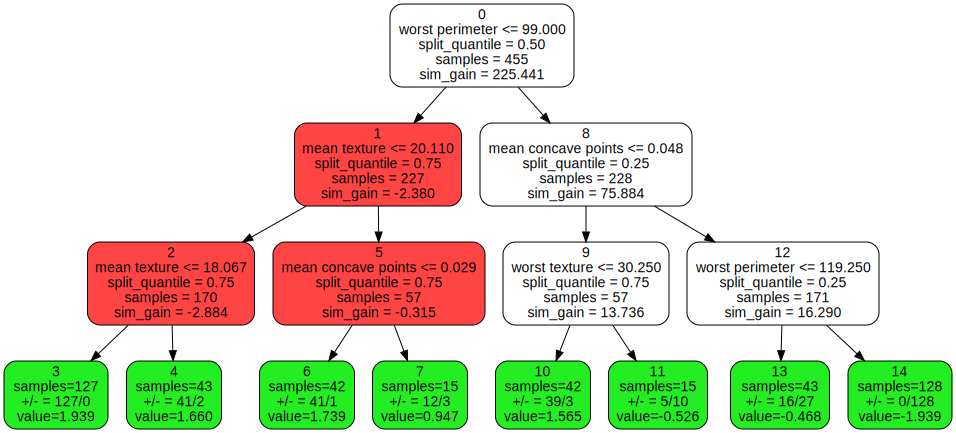

In [153]:
xdt = XGBTree()
xdt.fit(X_train, y_train-y_train0, y_train0)
dot_data=xdt.export_graphviz()
graph = graphviz.Source(dot_data) 
display(graph)

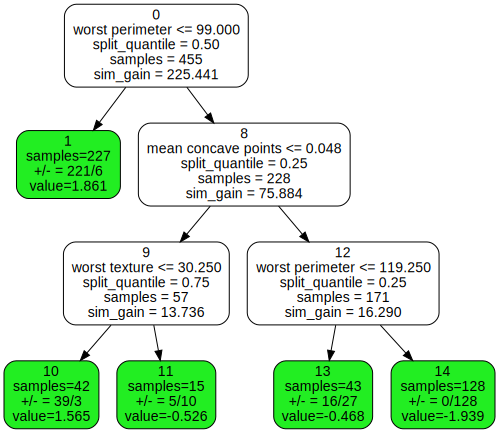

In [154]:
xdt.prune()
dot_data=xdt.export_graphviz()
graph = graphviz.Source(dot_data) 
display(graph)

In [150]:
display(xdt.score(X, y))
display(xdt.score(X_train, y_train))
display(xdt.score(X_test, y_test))

-20.364711041603673

-19.716999976664045

-23.29740442208057

## Step 1 Average

In [151]:
#now let's get started
learning_rate=0.3
loss = [0] * 6
residuals = np.zeros([6,n_train])
probabilities = np.zeros([6,n_train])
predictions = np.zeros([6,n_train])
log_of_odds = np.zeros([6,n_train])
gamma = np.zeros([6,n_train])
log_of_odds[0] = [0] * n_train
#calculation
#average_y=y.mean()
probabilities[0] = [0.5] * n_train
predictions[0] = [1] * n_train
residuals[0] = y_train - probabilities[0]
df_train['$f_0$']=np.array(predictions[0]).reshape((-1, 1))
df_train['$r_0$']=np.array(residuals[0]).reshape((-1, 1))
display(df_train)
loss0=-(y_train*np.log(probabilities[0])+(1-y_train)*np.log(1-probabilities[0]))
loss[0] = np.sum(loss0) / n_train
print(loss[0])
trees = []

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,one,y,$f_0$,$r_0$
0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.197400,0.127900,0.2069,0.05999,...,0.1444,0.42450,0.45040,0.24300,0.3613,0.08758,1.0,0,1.0,-0.5
1,12.31,16.52,79.19,470.9,0.09172,0.06829,0.033720,0.022720,0.1720,0.05914,...,0.1176,0.18430,0.17030,0.08660,0.2618,0.07609,1.0,1,1.0,0.5
2,11.63,29.29,74.87,415.1,0.09357,0.08574,0.071600,0.020170,0.1799,0.06166,...,0.1406,0.20310,0.29230,0.06835,0.2884,0.07220,1.0,1,1.0,0.5
3,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.243900,0.138900,0.1726,0.05623,...,0.1410,0.21130,0.41070,0.22160,0.2060,0.07115,1.0,0,1.0,-0.5
4,11.04,16.83,70.92,373.2,0.10770,0.07804,0.030460,0.024800,0.1714,0.06340,...,0.1369,0.14820,0.10670,0.07431,0.2998,0.07881,1.0,1,1.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,11.22,19.86,71.94,387.3,0.10540,0.06779,0.005006,0.007583,0.1940,0.06028,...,0.1424,0.09669,0.01335,0.02022,0.3292,0.06522,1.0,1,1.0,0.5
451,10.71,20.39,69.50,344.9,0.10820,0.12890,0.084480,0.028670,0.1668,0.06862,...,0.1335,0.25500,0.25340,0.08600,0.2605,0.08701,1.0,1,1.0,0.5
452,18.77,21.43,122.90,1092.0,0.09116,0.14020,0.106000,0.060900,0.1953,0.06083,...,0.1498,0.48270,0.46340,0.20480,0.3679,0.09870,1.0,0,1.0,-0.5
453,15.37,22.76,100.20,728.2,0.09200,0.10360,0.112200,0.074830,0.1717,0.06097,...,0.1257,0.19970,0.28460,0.14760,0.2556,0.06828,1.0,0,1.0,-0.5


0.6931471805599453


In the first step, we calculate the average 71.2 as the initial prediction. The pseudo residuals are 16.8, 4.8, etc.

## Step 2 For Loop

In [152]:
def iterate(i):
    t = XGBTree(max_depth=3, gamma=5)
    t.fit(X_train,residuals[i], probabilities[i])
    trees.append(t)
    
    dot_data = t.export_graphviz()
    graph = graphviz.Source(dot_data) 
    display(graph)
    t.prune()
    dot_data = t.export_graphviz()
    graph = graphviz.Source(dot_data) 
    display(graph)
    #next prediction, residual
    gamma[i]=t.predict(X_train)
    log_of_odds[i+1] = log_of_odds[i] + 0.3 * gamma[i]
    probabilities[i+1] = np.array([np.exp(odds)/(np.exp(odds)+1) for odds in log_of_odds[i+1]])
    predictions[i+1] = (probabilities[i+1]>0.5)*1.0
    residuals[i+1]=y_train-probabilities[i+1]
    loss[i+1]=np.sum(-y_train * log_of_odds[i+1] + np.log(1+np.exp(log_of_odds[i+1])))
    loss[i+1]=loss[i+1]/n_train
    y_hat=t.predict(X_train)
    
    new_df=df_train[['one','y']].copy()
    #new_df.columns=['name', 'popcorn','age','color','y']
    new_df[f'$p_{i}$']=probabilities[i]
    new_df[f'$l_{i}$']=log_of_odds[i]
    new_df[f'$r_{i}$']=residuals[i]
    new_df[f'$\gamma_{i}$']=gamma[i]
    new_df[f'$l_{i+1}$']=log_of_odds[i+1]
    new_df[f'$p_{i+1}$']=probabilities[i+1]
    display(new_df)
    
    #df_train[f'$\gamma_{i+1}$']=y_hat.reshape((-1,1))
    #df_train[f'$f_{i+1}$']=np.array(prediction[i+1]).reshape((-1,1))
    #df_train[f'$r_{i+1}$']=np.array(residuals[i+1]).reshape((-1,1))

    

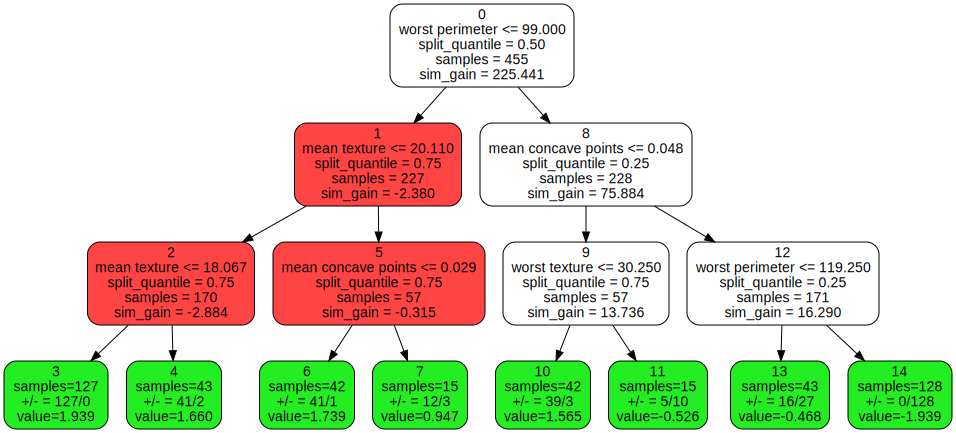

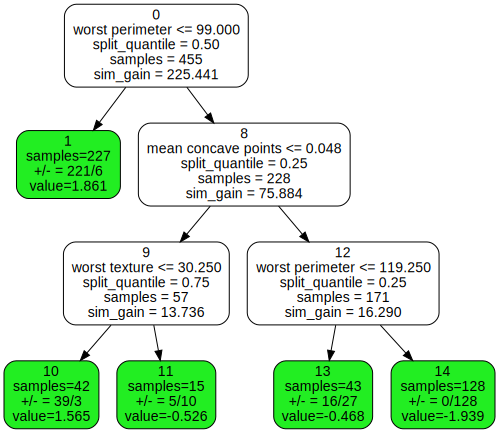

,one,y,$p_0$,$l_0$,$r_0$,$\gamma_0$,$l_1$,$p_1$
0,1.0,0,0.5,0.0,-0.5,-1.939394,-0.581818,0.358514
1,1.0,1,0.5,0.0,0.5,1.861472,0.558442,0.636092
2,1.0,1,0.5,0.0,0.5,1.861472,0.558442,0.636092
3,1.0,0,0.5,0.0,-0.5,-1.939394,-0.581818,0.358514
4,1.0,1,0.5,0.0,0.5,1.861472,0.558442,0.636092
...,...,...,...,...,...,...,...,...
450,1.0,1,0.5,0.0,0.5,1.861472,0.558442,0.636092
451,1.0,1,0.5,0.0,0.5,1.861472,0.558442,0.636092
452,1.0,0,0.5,0.0,-0.5,-1.939394,-0.581818,0.358514
453,1.0,0,0.5,0.0,-0.5,-0.468085,-0.140426,0.464951


In [135]:
iterate(0)

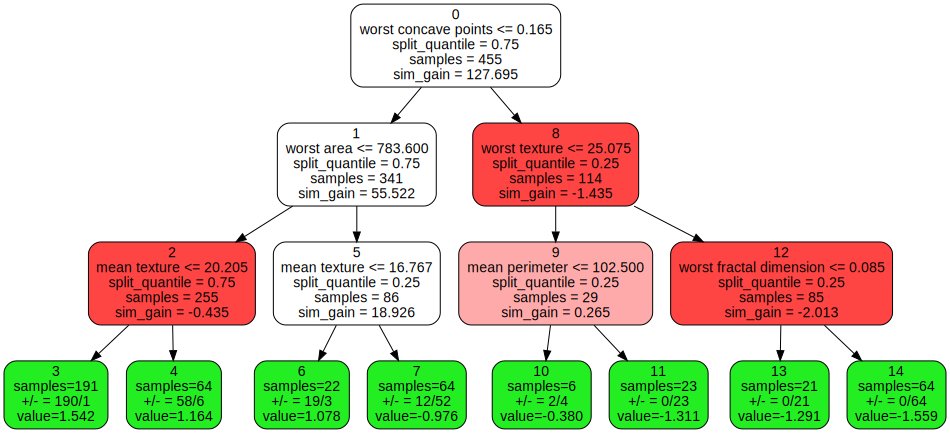

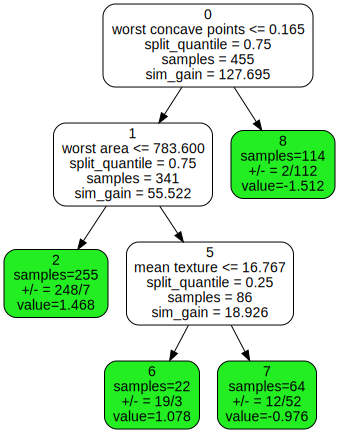

,one,y,$p_1$,$l_1$,$r_1$,$\gamma_1$,$l_2$,$p_2$
0,1.0,0,0.358514,-0.581818,-0.358514,-1.511592,-1.035296,0.262059
1,1.0,1,0.636092,0.558442,0.363908,1.467552,0.998707,0.730804
2,1.0,1,0.636092,0.558442,0.363908,1.467552,0.998707,0.730804
3,1.0,0,0.358514,-0.581818,-0.358514,-1.511592,-1.035296,0.262059
4,1.0,1,0.636092,0.558442,0.363908,1.467552,0.998707,0.730804
...,...,...,...,...,...,...,...,...
450,1.0,1,0.636092,0.558442,0.363908,1.467552,0.998707,0.730804
451,1.0,1,0.636092,0.558442,0.363908,1.467552,0.998707,0.730804
452,1.0,0,0.358514,-0.581818,-0.358514,-1.511592,-1.035296,0.262059
453,1.0,0,0.464951,-0.140426,-0.464951,-0.975950,-0.433210,0.393360


In [136]:
iterate(1)

In iteration 1, we firstly train a tree using residuals_1. This tree tells us height is also important in determining weight. Whose who are less than 1.55 meters are supported to lose -7.289 and the other to gain 7.289. Again, we want to shrink this to 20%, which is -1.4578 and 1.4578. We then make prediction_2 based on prediction_1 and $\gamma$. We see Alex gains 1.4578 kg because he is 1.6. Others also gain or lose weight because of the new rule.

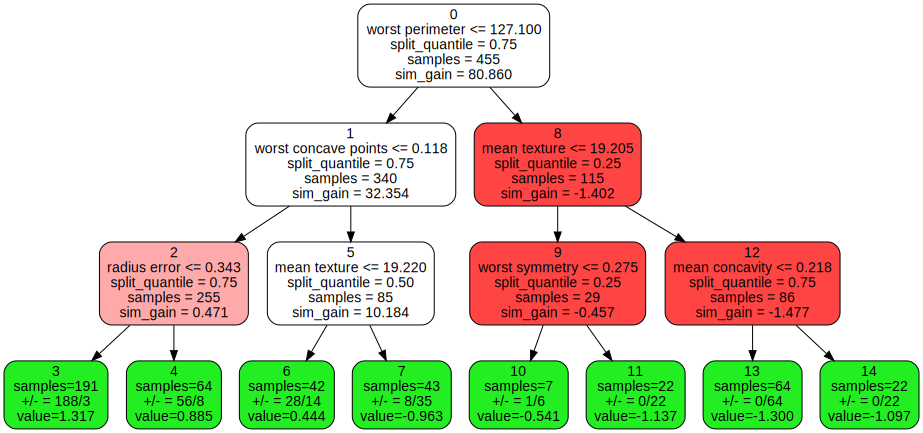

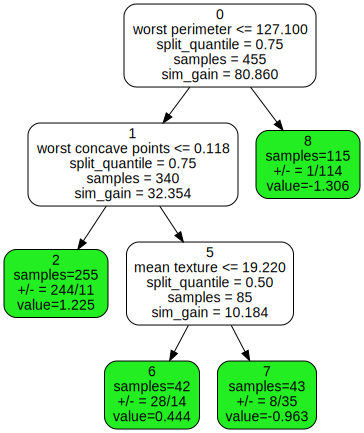

,one,y,$p_2$,$l_2$,$r_2$,$\gamma_2$,$l_3$,$p_3$
0,1.0,0,0.262059,-1.035296,-0.262059,-1.306233,-1.427166,0.193541
1,1.0,1,0.730804,0.998707,0.269196,1.225045,1.366221,0.796769
2,1.0,1,0.730804,0.998707,0.269196,1.225045,1.366221,0.796769
3,1.0,0,0.262059,-1.035296,-0.262059,-1.306233,-1.427166,0.193541
4,1.0,1,0.730804,0.998707,0.269196,1.225045,1.366221,0.796769
...,...,...,...,...,...,...,...,...
450,1.0,1,0.730804,0.998707,0.269196,1.225045,1.366221,0.796769
451,1.0,1,0.730804,0.998707,0.269196,1.225045,1.366221,0.796769
452,1.0,0,0.262059,-1.035296,-0.262059,-1.306233,-1.427166,0.193541
453,1.0,0,0.393360,-0.433210,-0.393360,-0.963380,-0.722224,0.326903


In [137]:
iterate(2)

Iteration 2 again tells us that gender matters.

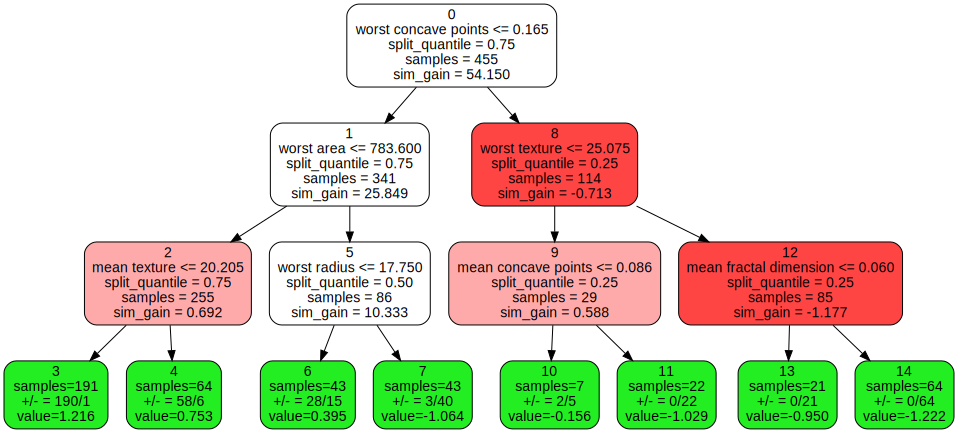

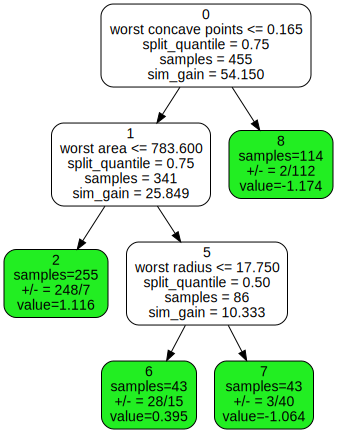

,one,y,$p_3$,$l_3$,$r_3$,$\gamma_3$,$l_4$,$p_4$
0,1.0,0,0.193541,-1.427166,-0.193541,-1.174473,-1.779507,0.144364
1,1.0,1,0.796769,1.366221,0.203231,1.115960,1.701009,0.845666
2,1.0,1,0.796769,1.366221,0.203231,1.115960,1.701009,0.845666
3,1.0,0,0.193541,-1.427166,-0.193541,-1.174473,-1.779507,0.144364
4,1.0,1,0.796769,1.366221,0.203231,1.115960,1.701009,0.845666
...,...,...,...,...,...,...,...,...
450,1.0,1,0.796769,1.366221,0.203231,1.115960,1.701009,0.845666
451,1.0,1,0.796769,1.366221,0.203231,1.115960,1.701009,0.845666
452,1.0,0,0.193541,-1.427166,-0.193541,-1.174473,-1.779507,0.144364
453,1.0,0,0.326903,-0.722224,-0.326903,0.394635,-0.603834,0.353467


In [138]:
iterate(3)

Iteration 3 argues that height is important, too.

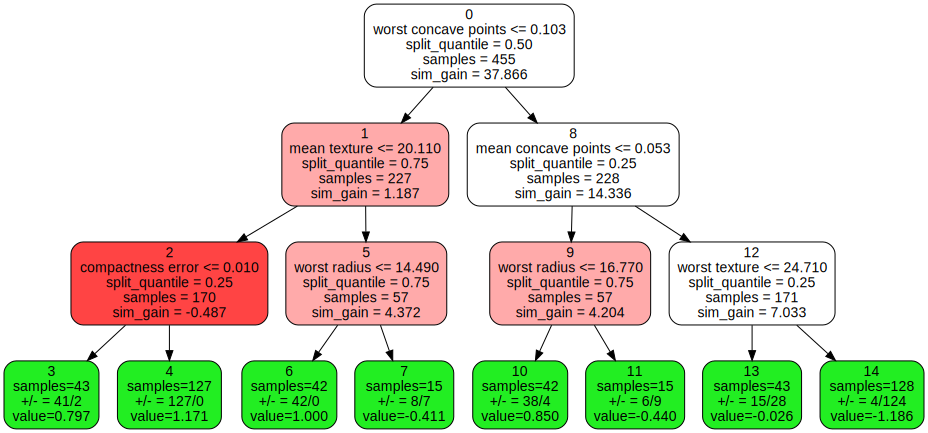

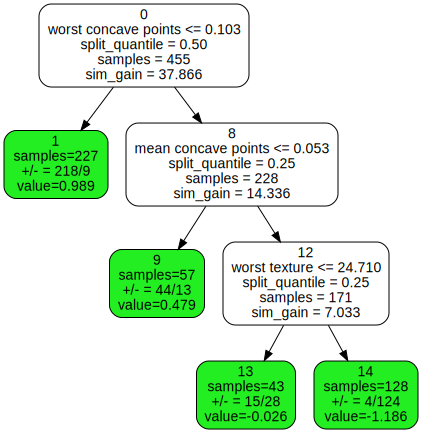

,one,y,$p_4$,$l_4$,$r_4$,$\gamma_4$,$l_5$,$p_5$
0,1.0,0,0.144364,-1.779507,-0.144364,-1.186255,-2.135384,0.105705
1,1.0,1,0.845666,1.701009,0.154334,0.989117,1.997744,0.880560
2,1.0,1,0.845666,1.701009,0.154334,0.989117,1.997744,0.880560
3,1.0,0,0.144364,-1.779507,-0.144364,-1.186255,-2.135384,0.105705
4,1.0,1,0.845666,1.701009,0.154334,0.989117,1.997744,0.880560
...,...,...,...,...,...,...,...,...
450,1.0,1,0.845666,1.701009,0.154334,0.989117,1.997744,0.880560
451,1.0,1,0.845666,1.701009,0.154334,0.989117,1.997744,0.880560
452,1.0,0,0.144364,-1.779507,-0.144364,-1.186255,-2.135384,0.105705
453,1.0,0,0.353467,-0.603834,-0.353467,-1.186255,-0.959710,0.276936


In [139]:
iterate(4)

Let's stop at Iteration 4. And take a look at the loss.

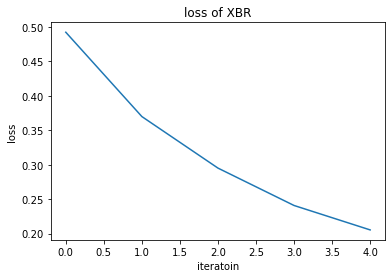

In [140]:
plt.plot(loss[1:])
plt.title('loss of XBR')
plt.xlabel('iteratoin')
plt.ylabel('loss')
plt.show()

In [261]:
class XGBClassifier():
    
    n_estimators = 100
    
    #now let's get started
    learning_rate=0.3
    trees = []
    loss = []
    residuals = np.zeros([100,n_train])
    probabilities = np.zeros([100,n_train])
    predictions = np.zeros([100,n_train])
    log_of_odds = np.zeros([100,n_train])
    gamma = np.zeros([100,n_train])
    log_of_odds[0] = [0] * n_train
    #calculation
    #average_y=y.mean()
    #probabilities[0] = [0.5] * n_train
    #predictions[0] = [1] * n_train
    #residuals[0] = y_train - probabilities[0]
    #loss0=-(y_train*np.log(probabilities[0])+(1-y_train)*np.log(1-probabilities[0]))
    #loss[0] = np.sum(loss0) / n_train
    
    
    def __init__(self, n_estimators=100):
        self.n_estimators = n_estimators
        pass
    
    def iterate(self, i, X_train, y_train):
        n_train=len(y_train)
        t = XGBTree(max_depth=3, gamma=5)
        t.fit(X_train,self.residuals[i], self.probabilities[i])
        t.prune()
        self.trees.append(t)
        

        self.gamma[i]=t.predict(X_train)
        self.log_of_odds[i+1] = self.log_of_odds[i] + 0.3 * self.gamma[i]
        self.probabilities[i+1] = np.array([np.exp(odds)/(np.exp(odds)+1) for odds in self.log_of_odds[i+1]])
        self.predictions[i+1] = (self.probabilities[i+1]>0.5)*1.0
        self.residuals[i+1]=y_train-self.probabilities[i+1]
        _loss=np.sum(-y_train * self.log_of_odds[i+1] + np.log(1+np.exp(self.log_of_odds[i+1])))/n_train
        self.loss.append(_loss)

    def fit(self, X_train, y_train):
        n_train=len(y_train)
        #n_estimators=10
        #now let's get started
        self.learning_rate=0.3
        self.loss = []
        self.trees = []
        self.residuals = np.zeros([self.n_estimators+1, n_train])
        self.probabilities = np.zeros([self.n_estimators+1, n_train])
        self.predictions = np.zeros([self.n_estimators+1, n_train])
        self.log_of_odds = np.zeros([self.n_estimators+1, n_train])
        self.gamma = np.zeros([self.n_estimators+1, n_train])
        self.log_of_odds[0] = [0] * n_train
        self.probabilities[0] = [0.5] * n_train
        self.predictions[0] = [1] * n_train
        self.residuals[0] = y_train - probabilities[0]
        loss0=-(y_train*np.log(probabilities[0])+(1-y_train)*np.log(1-probabilities[0]))
        loss0 = np.sum(loss0) / n_train
        self.loss.append(loss0)
        
        for i in range(self.n_estimators):
            self.iterate(i, X_train, y_train)

    def predict_proba(self, X):
        X = np.array(X)
        log_of_odds = np.array([0.0] * X.shape[0])
        for t in self.trees:
            log_of_odds+=t.predict(X)
        results = np.array([np.exp(odds)/(np.exp(odds)+1) for odds in log_of_odds])
        return results
    
    def predict(self, X):
        proba = self.predict_proba(X)
        results = (proba>0.5) * 1.0
        return results
    
    def accuracy(self, X, y):
        n=len(y)
        y_hat = self.predict(X)
        right = np.sum(y_hat == y)
        return right/n * 1.0

In [262]:
model = XGBClassifier(n_estimators=20)

In [263]:
model.fit(X_train, y_train)

In [264]:
model.predict(X_test)

array([0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1.,
       1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.])

In [265]:
model.accuracy(X_train, y_train)

0.978021978021978

In [266]:
model.accuracy(X_test, y_test)

0.9736842105263158

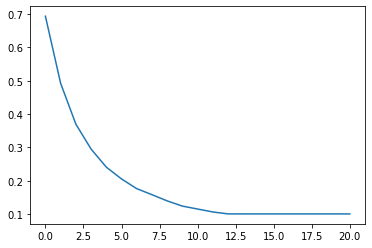

In [267]:
plt.plot(model.loss)

In [268]:
model.loss

[0.6931471805599453,
 0.4920249761454543,
 0.3697460183734479,
 0.2950323142486193,
 0.240828142219078,
 0.2054103758337053,
 0.17632670630889824,
 0.1582781253866065,
 0.13967314148610582,
 0.12400946534008836,
 0.11523353693563752,
 0.1064878341139898,
 0.10062734461302421,
 0.1006035233070387,
 0.10059143677695329,
 0.10058530987953208,
 0.10058220601751336,
 0.10058063431703279,
 0.10057983870693661,
 0.1005794360509627,
 0.10057923230001369]